**LOAD & PREPARE DATA**

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vishweshsalodkar/wild-animals")

print("Path to dataset files:", path)

100%|██████████| 7.37M/7.37M [00:01<00:00, 7.31MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/vishweshsalodkar/wild-animals/versions/2


In [19]:
import cv2
import os
import numpy as np

base_path = os.path.join(path, "Animals")
def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        try:
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (300, 300))
                images.append(img)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
    return images

categories = ["Cheetah", "Jaguar", "Leopard", "Lion", "Tiger"]
data = {category: load_images(os.path.join(base_path, category)) for category in categories}

data = {category: np.array(images) for category, images in data.items() if images}

print("Loaded images for each category:")
for category, images in data.items():
    print(f"{category}: {len(images)} images")


Loaded images for each category:
Cheetah: 38 images
Jaguar: 30 images
Leopard: 31 images
Lion: 32 images
Tiger: 39 images


**Grayscale Conversion**

Converted images to grayscale.


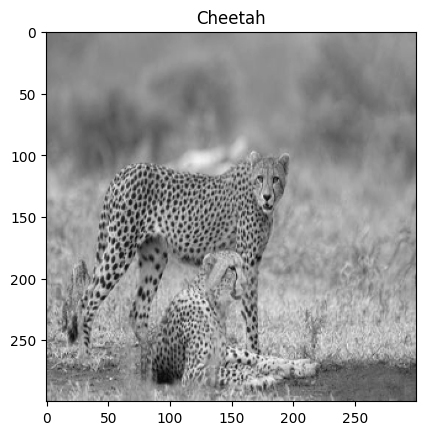

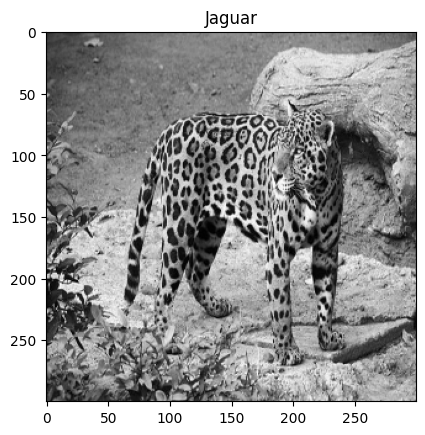

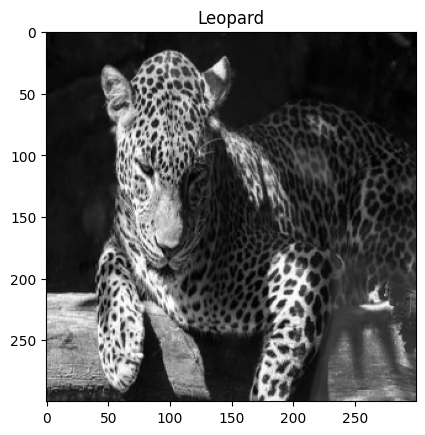

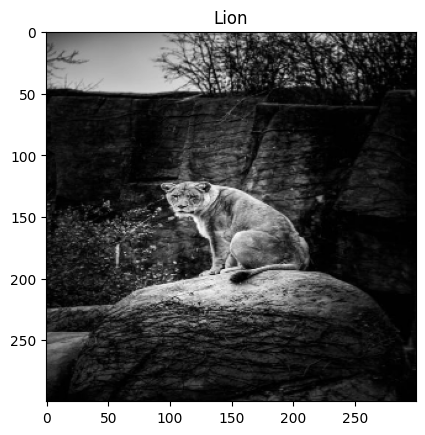

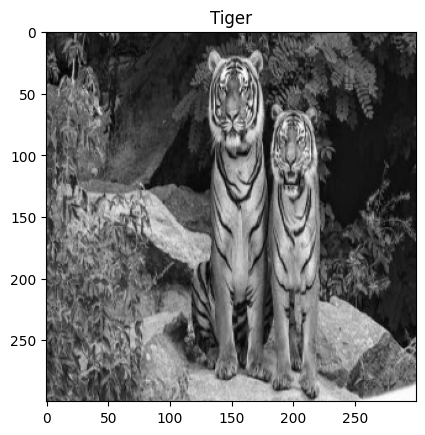

In [20]:
# converting images to grayscale
import matplotlib.pyplot as plt
def convert_grayscale(images):
    return np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images])

data_gray = {category: convert_grayscale(images) for category, images in data.items()}

print("Converted images to grayscale.")
for category, images in data_gray.items():
    if len(images) > 0:
        plt.imshow(images[0], cmap='gray')
        plt.title(category)
        plt.show()


**Labeling**

In [21]:
# Assign labels to categories
label_map = {category: idx for idx, category in enumerate(categories)}
all_images = []
all_labels = []

for category, images in data_gray.items():
    all_images.extend(images)
    all_labels.extend([label_map[category]] * len(images))

all_images = np.array(all_images)
all_labels = np.array(all_labels)

print("Combined all images and labels:")
print(f"Total images: {len(all_images)}, Total labels: {len(all_labels)}")


Combined all images and labels:
Total images: 170, Total labels: 170


**K-NN & Cross Validation & Plotting**

Processing Fold 1
  k=1: Accuracy=0.3235
  k=2: Accuracy=0.2647
  k=3: Accuracy=0.2353
  k=4: Accuracy=0.2647
  k=5: Accuracy=0.3235
  k=6: Accuracy=0.2941
  k=7: Accuracy=0.3529
  k=8: Accuracy=0.3235
  k=9: Accuracy=0.3529
  k=10: Accuracy=0.3529
  k=11: Accuracy=0.3529
  k=12: Accuracy=0.3529
  k=13: Accuracy=0.3824
  k=14: Accuracy=0.3824
  k=15: Accuracy=0.3529
  k=16: Accuracy=0.4118
  k=17: Accuracy=0.3529
  k=18: Accuracy=0.3824
  k=19: Accuracy=0.4118
  k=20: Accuracy=0.3824
  k=21: Accuracy=0.3824
  k=22: Accuracy=0.3824
  k=23: Accuracy=0.3529
  k=24: Accuracy=0.3529
  k=25: Accuracy=0.3824
  k=26: Accuracy=0.4412
  k=27: Accuracy=0.3529
  k=28: Accuracy=0.2941
  k=29: Accuracy=0.2941
  k=30: Accuracy=0.3235
Processing Fold 2
  k=1: Accuracy=0.2353
  k=2: Accuracy=0.1765
  k=3: Accuracy=0.2941
  k=4: Accuracy=0.3235
  k=5: Accuracy=0.2941
  k=6: Accuracy=0.3235
  k=7: Accuracy=0.3824
  k=8: Accuracy=0.3235
  k=9: Accuracy=0.2647
  k=10: Accuracy=0.2941
  k=11: Accuracy=0.294

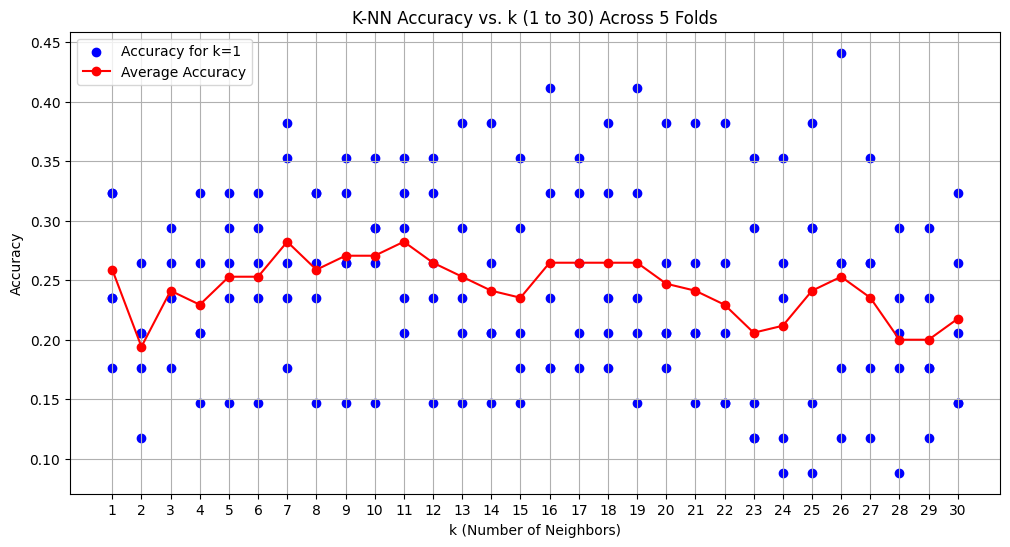

In [22]:
import random as random
import numpy as np
import matplotlib.pyplot as plt


def calculate_distances(test_image, training_set):
    distances = [np.linalg.norm(test_image - train_image) for train_image in training_set]
    return distances

# Function for k-NN
def knn(training_set, training_labels, test_image, k):
    distances = calculate_distances(test_image, training_set)
    sorted_indices = np.argsort(distances)[:k]
    k_nearest_labels = [training_labels[i] for i in sorted_indices]
    return max(set(k_nearest_labels), key=k_nearest_labels.count)

# Function to create k folds
def create_folds(data, labels, num_folds=5):
    combined = list(zip(data, labels))
    random.shuffle(combined)
    data, labels = zip(*combined)
    fold_size = len(data) // num_folds
    folds = []
    for i in range(num_folds):
        start_index = i * fold_size
        end_index = (i + 1) * fold_size if i < num_folds - 1 else len(data)
        folds.append((data[start_index:end_index], labels[start_index:end_index]))
    return folds

k_values = list(range(1, 31))  # k = 1 to 30
folds = create_folds(all_images, all_labels, num_folds=5)
fold_accuracies = {k: [] for k in k_values}

# Perform 5-fold cross-validation
for fold_idx, (validation_data, validation_labels) in enumerate(folds):
    print(f"Processing Fold {fold_idx + 1}")

    training_data = [image for i, (data, _) in enumerate(folds) if i != fold_idx for image in data]
    training_labels = [label for i, (_, lbls) in enumerate(folds) if i != fold_idx for label in lbls]

    for k in k_values:
        correct_predictions = 0
        for i, test_image in enumerate(validation_data):

            prediction = knn(training_data, training_labels, test_image, k)
            if prediction == validation_labels[i]:
                correct_predictions += 1

        accuracy = correct_predictions / len(validation_data)
        fold_accuracies[k].append(accuracy)
        print(f"  k={k}: Accuracy={accuracy:.4f}")

average_accuracies = {k: np.mean(fold_accuracies[k]) for k in k_values}

plt.figure(figsize=(12, 6))

for k in k_values:
    plt.scatter([k] * len(fold_accuracies[k]), fold_accuracies[k], color='blue', label=f'Accuracy for k={k}' if k == 1 else "")

plt.plot(k_values, list(average_accuracies.values()), marker='o', linestyle='-', color='red', label='Average Accuracy')

plt.title("K-NN Accuracy vs. k (1 to 30) Across 5 Folds")
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Accuracy")
plt.xticks(k_values)
plt.grid(True)
plt.legend(loc='best')
plt.show()
